# Projet numérique de science des données 2021
## LOUISOT Pierre 
## POLLET Florent

## Introduction au projet

Il s'agit dans ce projet d'utiliser des données cartographiques décrivant des carrées de 30m x 30m pour construire un modèle prédictif de l'espèce d'arbre présente sur un tel carré.

Le but final est d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette.

__Consignes :__ 
* Vous devez rendre, par binôme :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms/prénoms__ dans le titre du notebook
* Vous avez jusqu'au __1er juillet midi heure de Paris__
* Déposez vos fichiers [sur Campus](https://campus.mines-paristech.fr/course/view.php?id=404) dans la section dédiée (un seul rendu par binôme est nécessaire)


__Déroulé :__
* Les séances du lundi 14/06 (15h30-17h) et jeudi 24/06 (15h30-17h) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 14/06 ; c'est indiqué le cas échéant.

## Données

### Données publiques et privées

Le dossier `data/` contient deux jeux de données :
* `data/foret_public.tsv` contient les données étiquetées, à partir desquelles construire votre modèle
* `data/foret_prive.tsv` contient les données non-étiquetées, pour lesquelles faire vos prédictions.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* `altitude` : altitude en mètres
* `exposition` : azimut en degrés 
* `pente` : pente en degrés
* `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
* `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
* `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
* `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
* `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
* `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
* `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* `espece` : étiquette : espèce d'arbre présente (0 = pin tordu ; 1 = peuplier)|

### Chargement des données étiquetées

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from sklearn import preprocessing

In [3]:
df_public = pd.read_csv('data/foret_public.tsv', delimiter='\t')

In [4]:
df_public.head()

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,espece
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


### Extraction de la matrice de design et des étiquettes 

In [5]:
X_public = np.array(df_public.drop(columns=["espece"]))
y_public = np.array(df_public["espece"])

In [6]:
df_public.head(100)

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,espece
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0
...,...,...,...,...,...,...,...,...,...,...,...
95,3077,129,3,618,43,6296,225,237,147,3261,0
96,2755,320,4,30,-1,2890,209,236,165,5468,0
97,2880,86,12,30,3,4369,237,221,113,5906,0
98,2827,332,15,42,9,3599,185,221,174,6067,0


### Visualisation des variables

#### Question 1
Visualisez chacune des variables de `X_public` sous la forme de deux histogrammes superposés, l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative.

__Conseils :__
* utilisez `pos_indices = np.where(y_public==1)[0]` pour déterminer les indices des lignes de `y_public` (et donc dans `X_public`) dont l'étiquette vaut 0.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

In [ ]:
def plot_hist(X_public, title=""):  
    """
        Retourne, pour chacune des variables de df_public, deux histogrammes superposés, l'un pour la classe positive et l'autre pour la classe négative
    """
    
    features = list(df_public.drop(columns=['espece']).columns) # Noms des colonnes
    
    X_public_pos = X_public[np.where(y_public==1)[0]] # Lignes correspondant à des peupliers
    X_public_neg = X_public[np.where(y_public==0)[0]] # Lignes correspondant à des pins tordus
    
    features_idx = [features.index(feat_name) for feat_name in features] # indices des colonnes

    fig = plt.figure(figsize=(8, 6))

    # Histograms for continuous features
    for plot_idx, feat_idx in enumerate(features_idx):
        
        # create a subplot in the (plot_idx+1) position of a 2x2 grid
        ax = fig.add_subplot(5, 2, (plot_idx+1))
        # plot the histograms of feat_idx
        h1 = ax.hist(X_public_pos[feat_idx], bins=30, edgecolor='none', alpha=0.2, label="peupliers")
        h2 = ax.hist(X_public_neg[feat_idx], bins=30, edgecolor='none', alpha=0.2, label="pins tordus")
        # use the name of the feature as a title for each histogram
        ax.set_title(features[feat_idx])
        if plot_idx == 0:
            fig.legend(loc='upper right', bbox_to_anchor=(0, 1))
            
    fig.tight_layout(pad=1.0)
    fig.suptitle("Histogrammes pour chaque variable des classes positive et négative " + title, y=0)

In [ ]:
plot_hist(X_public)

#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

*A priori, on ne distingue pas de critères simples permettant de classer les arbres suivant leur espèce. En effet, on observe des zones de recouvrement entre les deux espèces pour la plupart des paramètres.*

### Pré-traitement des variables

#### Question 3
Transformez vos variables d'une manière qui vous parait judicieuse, en vous appuyant notamment sur la PC 3. Vous pouvez essayer différents pré-traitements, mais ce n'est pas nécessaire. Justifiez vos choix. Utilisez un array numpy `X_public_preprocessed` pour enregistrer le résultat.

In [ ]:
# Yeo-Johnson
yj_scaler = preprocessing.PowerTransformer(method='yeo-johnson')
yj_scaler.fit(X_public)
X_public_preprocessed = yj_scaler.transform(X_public)

# Standard Scaler
s_scaler = preprocessing.StandardScaler()
s_scaler.fit(X_public)
X_public_preprocessed_s = s_scaler.transform(X_public)

*On peut tout d'abord centrer et réduire les données, afin que les différentes grandeurs soient comparables, à l'aide de la classe StandardScaler.*

*Une autre idée serait de réaliser un prétraitement non-linéaire des données, prenant en compte l'asymétrie des données.*

*Cependant, la méthode Box-Cox vue en cours ne tolère pas les valeurs négatives. On utilise donc la méthode Yeo-Johnson, qui est également une transformation normale mais supportant les valeurs négatives.*

In [ ]:
# affichage
plot_hist(X_public_preprocessed, "(Yeo-Johnson)")
plot_hist(X_public_preprocessed_s, "(normalisation standard)")

*On observe bien des données mieux réparties et normalisées, avec toujours des phénomènes de recouvrement.*

## Premier modèle : 5-NN

### Algorithme des k plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=5.

#### Question 4

Entraînez un modèle des sur les données `(X_public_preprocessed, y_public)` grâce à la classe `KNeighborsClassifier` du module `neighbors` de `sklearn`, utilisez l'algorithme des 5 plus proches voisins pour entrainer un modèle sur votre jeu d'entraînement.

Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
from sklearn import neighbors

*D'après la documentation, on écrit le code suivant :*

In [ ]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=5) 
neigh.fit(X_public_preprocessed, y_public)

### Performance

Il existe de nombreuses métriques pour évaluer les performances d'un algorithme de classification. Nous allons ici utiliser le F-score, dont vous trouverez une description dans la documentation du module `metrics` de `sklearn` : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score et https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics.

#### Question 5
Quel serait sur nos données le F-score d'un modèle naïf prédisant systématiquement la classe positive ?

*On utilise le mode 'binary' car on est face à un problème de classification binaire.*

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_public, [1]*len(y_public), average='binary')

*On obtient environ 0.67, on s'attend par la suite à un F-score plus proche de 1.*

#### Question 6

Quelle est le F-score du modèle de 5 plus proches voisins que vous venez d'entraîner, sur les données `(X_public_preprocessed, y_public)` ?

In [14]:
y_pred = neigh.predict(X_public_preprocessed)
f1_score(y_public, y_pred, average='binary')

0.9276089000313382

In [15]:
# Résultat pour le preprossing StandardScaler

neigh_s = neighbors.KNeighborsClassifier(n_neighbors=5) 
neigh_s.fit(X_public_preprocessed_s, y_public)
y_pred = neigh_s.predict(X_public_preprocessed_s)
f1_score(y_public, y_pred, average='binary')

0.9290079924776682

*On observe des performances comparables pour les différents prétraitements.*

#### Question 7
* Que pensez-vous de cette performance ? 
* Est-ce une bonne idée d'évaluer le modèle sur le jeu d'entraînement ? (Réfléchissez en particulier au cas où k=1.)

*La performance est bonne, meilleure que l'aléatoire. Elle peut cependant être améliorée assez facilement, par exemple en utilisant un mode de pondération différent (distance, qui donne un F-score de 1 sur ces données avec le prétraitement Yeo-Johnson).*

*Cette performance peut s'expliquer par un phénomène de surapprentissage, qui est d'autant plus marqué que $k$ est faible. Ainsi, dans le cas $k=1$, on assiste à un apprentissage par coeur. Ce dernier donne ici de très bons résultats (F-score de 1), mais cela est dû au fait que le modèle est testé sur le jeu d'entrainement (cf cellule ci-dessous).*

In [16]:
# Calcul du F-score avec k=1, prétraitement Yeo-Johnson (apprentissage par coeur)

neigh = neighbors.KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_public_preprocessed, y_public)
y_pred = neigh.predict(X_public_preprocessed)
f1_score(y_public, y_pred, average='binary') 

1.0

## Création d'un jeu de test

À partir de maintenant, nous allons séparer les données en un jeu d'entraînement, que nous utiliserons pour entraîner différents modèles, et un jeu de test, que nous utiliserons pour les comparer. (Cf CM 8).

In [17]:
from sklearn import model_selection

In [18]:
# Use 20% for testing

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_public, y_public, test_size=0.20,
                                                                    stratify=y_public,
                                                                    random_state=42) 
X_train.shape, X_test.shape
print(y_test)

[0 0 0 ... 0 1 1]


*On normalise les jeux d'entrainement et de test par les mêmes méthodes que précédemment.*

In [19]:
# Jeux d'entrainement avec Yeo-Johnson
yj_scaler = preprocessing.PowerTransformer(method='yeo-johnson')
yj_scaler.fit(X_train)
X_train_preprocessed = yj_scaler.transform(X_train)
X_test_preprocessed = yj_scaler.transform(X_test)

C:\Users\Florent\.conda\envs\sdd2021\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [20]:
# Jeux d'entrainement avec le StandardScaler
s_scaler = preprocessing.StandardScaler()
s_scaler.fit(X_train)
X_train_preprocessed_s = s_scaler.transform(X_train)
X_test_preprocessed_s = s_scaler.transform(X_test)

### Performance sur le jeu de test d'un 5-NN entraîné sur le jeu d'entrainement

#### Question 8.a 

Entrainez de nouveau un modèle avec l'algorithme des 5 plus proches voisins, mais cette fois, utilisez uniquement le jeu d'entraînement. __Attention__ à bien « entraîner » votre pre-processing sur le jeu d'entraînement seulement ; considérez le jeu de test comme des données que vous ne voyez pas au moment de l'entraînement.

In [21]:
# Entrainement sur le jeu d'entrainement
neigh_train = neighbors.KNeighborsClassifier(n_neighbors=5)
neigh_train.fit(X_train_preprocessed, y_train)

KNeighborsClassifier()

#### Question 8.b
Évaluez le F-score sur le jeu de test du modèle entraîné à la question précédente.

In [22]:
# Pour le Yeo-Johnson

y_pred = neigh_train.predict(X_test_preprocessed)
f1_score(y_test, y_pred, average='binary')

0.8630769230769231

In [33]:
# Valeur pour le StandardScaler
neigh_train_s = neighbors.KNeighborsClassifier(n_neighbors=5)
neigh_train_s.fit(X_train_preprocessed_s, y_train)
y_pred = neigh_train_s.predict(X_test_preprocessed_s)
f1_score(y_test, y_pred, average='binary')

0.8956587966488957

*On observe que le résultat est meilleur avec le prétraitement de StandardScaler.*

#### Question 9
Commentez le F-score obtenu ci-dessus.

*Dans les deux cas, le F-score calculé est inférieur à celui obtenu précédemment. En effet, le phénomène de surapprentissage, qui n'est plus possible avec les données de test, gonflait artificiellement le F-score. Si la note obtenue est inférieure, elle est néanmoins plus représentative des performances réelles du modèle.*

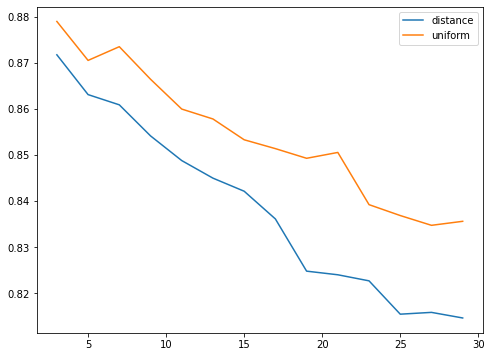

In [38]:
def f_score(k=5, weights="uniform", x_test = X_test_preprocessed, x_train = X_train_preprocessed):
    """
    Calcule le F-score pour les paramètres passés en arguments avec le modèle kNN
    """
    neigh_train = neighbors.KNeighborsClassifier(n_neighbors=k, weights=weights)
    neigh_train.fit(x_train, y_train)
    y_pred = neigh_train.predict(x_test)
    return f1_score(y_test, y_pred, average='binary')


fig = plt.figure(figsize=(8, 6))

idx = [2*i+1 for i in range(1, 15)]
pts = []
pts_dist = []
for k in idx:        
    pts.append(f_score(k))  
    pts_dist.append(f_score(k, "distance"))

plt.plot(idx, pts, label="distance")
plt.plot(idx, pts_dist, label="uniform")
plt.legend();


## [À partir du CM 8 / de la PC 4] Sélection du nombre de plus proches voisins

#### Question 10.a 
Utilisez maintenant une validation croisée pour sélectionner la valeur optimale du nombre de voisins avec `GridSearchCV` (voir notamment PC4). 

Vous pouvez utiliser la grille de valeurs de k suivante, ou la modifier :

In [39]:
# Paramètres testés
n_neighbors = np.arange(1, 15, step=1)

In [40]:
from sklearn.model_selection import GridSearchCV

# Validation croisée
kneighbors_model = neighbors.KNeighborsClassifier()
tuned_parameters = [{'n_neighbors': n_neighbors}]
nb_folds = 5
grid = GridSearchCV(kneighbors_model, tuned_parameters, cv=nb_folds, refit=True, verbose=3, scoring='f1')
grid.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.864 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.863 total time=   0.1s
[CV 3/5] END .....................n_neighbors=1;, score=0.858 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.855 total time=   0.1s
[CV 5/5] END .....................n_neighbors=1;, score=0.873 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.848 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.834 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.834 total time=   0.1s
[CV 4/5] END .....................n_neighbors=2;, score=0.831 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.852 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.872 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}],
             scoring='f1', verbose=3)

#### Question 10.b
Quel est le F-score correspondant au nombre de voisin optimal ?

In [315]:
# Pour le Yeo-Johnson

k_opti = grid.best_params_['n_neighbors']
f_max = grid.best_score_
print("k", k_opti)
print("F-score", f_max)

k 3
F-score 0.8635888371024347


In [316]:
# pour le preprocessing StandardScaler

kneighbors_model = neighbors.KNeighborsClassifier()
tuned_parameters = [{'n_neighbors': n_neighbors}]
nb_folds = 5
grid_s = GridSearchCV(kneighbors_model, tuned_parameters, cv=nb_folds, refit=True, verbose=3, scoring='f1')
grid_s.fit(X_train_preprocessed_s, y_train)
k_opti = grid_s.best_params_['n_neighbors']
f_max = grid_s.best_score_
print("k", k_opti)
print("f_max", f_max)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.883 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.909 total time=   0.1s
[CV 3/5] END .....................n_neighbors=1;, score=0.906 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.886 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.911 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.883 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.894 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.898 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.871 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.905 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.898 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;

*Le prétraitement StandardScaler donne toujours de meilleurs résultats que Yeo-Johnson.*

#### Question 10.c

Quel est le F-score, sur le jeu de test, d'un modèle obtenu en entraînant un algorithme des k plus proches voisins, avec le k que vous venez de déterminer, sur le jeu d'entraînement ? Commentez.

In [317]:
# Pour le Yeo-Johnson

esti = grid.best_estimator_
y_pred_train = esti.predict(X_train_preprocessed)
y_pred_test = esti.predict(X_test_preprocessed)
print("Jeu d'entrainement", f1_score(y_train, y_pred_train, average='binary'))
print("Jeu de test", f1_score(y_test, y_pred_test, average='binary'))

Jeu d'entrainement 0.9301128489408037
Jeu de test 0.8717156105100463


In [318]:
# Pour le StandardScaler

esti_s = grid_s.best_estimator_
y_pred_train_s = esti_s.predict(X_train_preprocessed_s)
y_pred_test_s = esti_s.predict(X_test_preprocessed_s)
print("Jeu d'entrainement", f1_score(y_train, y_pred_train_s, average='binary'))
print("Jeu de test", f1_score(y_test, y_pred_test_s, average='binary'))

Jeu d'entrainement 1.0
Jeu de test 0.9138339920948617


Quel que soit le preprocessing, on n'observe pas de variations significatives de la performance entre les performances sur le jeu de test et la moyenne calculée lors de la validation croisée. Toutefois, et à nouveau quel que soit le prétraitement, on observe un surapprentissage sur le jeu d'entrainement en entier.

On remarque que les modèles se comportent mieux avec peu de voisins. Cependant, malgré un bon F-score, cela pose la question de la pertinence d'une vision continue de la répartition des espèces, qui est l'intuition sur laquelle repose le modèle des plus proches voisins (encore plus lorsque l'on choisit comme pondération la distance). En effet, la meilleure prédiction est obtenue lorsque l'on ne tient compte que du plus proche voisin ce qui souligne le caractère erratique de la répartition forestière.

## [À partir de la PC 5] Régression logistique

### Régression logistique non-régularisée

#### Question 11.a

Entraînez une régression logistique non-régularisée sur le jeu d'entraînement.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `LogisticRegression` du module `linear_model` de `scikit-learn` ; il s'agit ainsi d'une variante de la PC5. Comme toujours, référez-vous à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
* Pour ne pas avoir de régularisation, utilisez `penalty='none'`

In [26]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Régression logistique sur le jeu d'entrainement
log_reg = LogisticRegression(penalty='none')
log_reg.fit(X_train_preprocessed, y_train)

LogisticRegression(penalty='none')

#### Question 11.b
Évaluez le F-score de cette régression logistique non-régularisée sur le jeu de test.

In [43]:
# Pour le Yeo-Johnson

y_pred = log_reg.predict(X_test_preprocessed)
print("Jeu d'entrainement", f1_score(y_train, log_reg.predict(X_train_preprocessed), average='binary'))
print("Jeu de test", f1_score(y_test, y_pred, average='binary'))

Jeu d'entrainement 0.7023759899958315
Jeu de test 0.7085714285714286


In [44]:
# Pour le Standard Scaler

log_reg_s = LogisticRegression(penalty='none')
log_reg_s.fit(X_train_preprocessed_s, y_train)
y_pred_s = log_reg_s.predict(X_test_preprocessed_s)
print("Jeu d'entrainement", f1_score(y_train, log_reg_s.predict(X_train_preprocessed_s), average='binary'))
print("Jeu de test", f1_score(y_test, y_pred_s, average='binary'))

Jeu d'entrainement 0.7724933086267243
Jeu de test 0.7756778964667215


#### Question 12
Vous attendez-vous à ce qu'utiliser une régularisation l2 améliore les performances du modèle ? Pourquoi ?

Pour les deux prétraitements, le F-score sur le jeu d'entrainement est plutôt faible et proche de celui du jeu de test, il n'y a donc a priori pas de surapprentissage. Or, la régularisation Ridge a pour but de limiter le surapprentissage. Par conséquent, on ne s'attend pas à une amélioration significative des performances sur le jeu de test par l'ajout d'une régularisation Ridge.

#### Question 13.a
Déterminez par validation croisée une valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.

In [49]:
# Valeurs à tester de l'hyperparamètre
reg_coef =  np.logspace(-4, 4, 30)

# Régularisation Ridge (Yeo-Johnson)
log_reg = LogisticRegression(penalty='l2', max_iter=10000)
tuned_parameters = [{'C': reg_coef}]
nb_folds = 5
grid = GridSearchCV(log_reg, tuned_parameters, cv=nb_folds, refit=True, verbose=3, scoring='f1')
grid.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..........................C=0.0001;, score=0.651 total time=   0.0s
[CV 2/5] END ..........................C=0.0001;, score=0.641 total time=   0.0s
[CV 3/5] END ..........................C=0.0001;, score=0.666 total time=   0.0s
[CV 4/5] END ..........................C=0.0001;, score=0.657 total time=   0.0s
[CV 5/5] END ..........................C=0.0001;, score=0.637 total time=   0.0s
[CV 1/5] END ..........C=0.00018873918221350977;, score=0.650 total time=   0.0s
[CV 2/5] END ..........C=0.00018873918221350977;, score=0.654 total time=   0.0s
[CV 3/5] END ..........C=0.00018873918221350977;, score=0.674 total time=   0.0s
[CV 4/5] END ..........C=0.00018873918221350977;, score=0.663 total time=   0.0s
[CV 5/5] END ..........C=0.00018873918221350977;, score=0.637 total time=   0.0s
[CV 1/5] END ...........C=0.0003562247890262444;, score=0.656 total time=   0.0s
[CV 2/5] END ...........C=0.0003562247890262444

[CV 3/5] END ...............C=32.90344562312671;, score=0.710 total time=   0.0s
[CV 4/5] END ...............C=32.90344562312671;, score=0.698 total time=   0.0s
[CV 5/5] END ...............C=32.90344562312671;, score=0.694 total time=   0.0s
[CV 1/5] END ...............C=62.10169418915616;, score=0.704 total time=   0.0s
[CV 2/5] END ...............C=62.10169418915616;, score=0.697 total time=   0.0s
[CV 3/5] END ...............C=62.10169418915616;, score=0.710 total time=   0.0s
[CV 4/5] END ...............C=62.10169418915616;, score=0.698 total time=   0.0s
[CV 5/5] END ...............C=62.10169418915616;, score=0.694 total time=   0.0s
[CV 1/5] END ..............C=117.21022975334793;, score=0.704 total time=   0.0s
[CV 2/5] END ..............C=117.21022975334793;, score=0.697 total time=   0.0s
[CV 3/5] END ..............C=117.21022975334793;, score=0.710 total time=   0.0s
[CV 4/5] END ..............C=117.21022975334793;, score=0.698 total time=   0.0s
[CV 5/5] END ..............C

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid=[{'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04])}],
             scoring='f1', verbose=3)

#### Question 13.b
Quel est le F-score, sur le jeu de test, d'une régression logistique avec régularisation ridge et ce coefficient de régularisation optimal, entraînée sur le jeu d'entraînement ?

In [48]:
# Régularisation Ridge (Yeo-Johnson)

print(grid.best_score_)
print(grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test_preprocessed)
print(f1_score(y_test, y_pred, average='binary'))

0.7014538409120783
{'C': 0.20433597178569418}
0.7079934747145188


In [324]:
# Régularisation Lasso (Yeo-Johnson)

log_reg = LogisticRegression(penalty='l1', max_iter=10000, solver='saga')
tuned_parameters = [{'C': reg_coef}]
nb_folds = 5
grid = GridSearchCV(log_reg, tuned_parameters, cv=nb_folds, refit=True, verbose=3, scoring='f1')
grid.fit(X_train_preprocessed, y_train)
print(grid.best_score_)
print(grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test_preprocessed)
print(f1_score(y_test, y_pred, average='binary'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..........................C=0.0001;, score=0.000 total time=   0.0s
[CV 2/5] END ..........................C=0.0001;, score=0.000 total time=   0.0s
[CV 3/5] END ..........................C=0.0001;, score=0.000 total time=   0.0s
[CV 4/5] END ..........................C=0.0001;, score=0.000 total time=   0.0s
[CV 5/5] END ..........................C=0.0001;, score=0.667 total time=   0.0s
[CV 1/5] END ..........C=0.00018873918221350977;, score=0.000 total time=   0.0s
[CV 2/5] END ..........C=0.00018873918221350977;, score=0.667 total time=   0.0s
[CV 3/5] END ..........C=0.00018873918221350977;, score=0.000 total time=   0.0s
[CV 4/5] END ..........C=0.00018873918221350977;, score=0.667 total time=   0.0s
[CV 5/5] END ..........C=0.00018873918221350977;, score=0.667 total time=   0.0s
[CV 1/5] END ...........C=0.0003562247890262444;, score=0.000 total time=   0.0s
[CV 2/5] END ...........C=0.0003562247890262444

[CV 5/5] END ...............C=62.10169418915616;, score=0.694 total time=   0.0s
[CV 1/5] END ..............C=117.21022975334793;, score=0.704 total time=   0.0s
[CV 2/5] END ..............C=117.21022975334793;, score=0.697 total time=   0.0s
[CV 3/5] END ..............C=117.21022975334793;, score=0.710 total time=   0.0s
[CV 4/5] END ..............C=117.21022975334793;, score=0.698 total time=   0.0s
[CV 5/5] END ..............C=117.21022975334793;, score=0.694 total time=   0.0s
[CV 1/5] END ..............C=221.22162910704503;, score=0.704 total time=   0.0s
[CV 2/5] END ..............C=221.22162910704503;, score=0.697 total time=   0.0s
[CV 3/5] END ..............C=221.22162910704503;, score=0.710 total time=   0.0s
[CV 4/5] END ..............C=221.22162910704503;, score=0.698 total time=   0.0s
[CV 5/5] END ..............C=221.22162910704503;, score=0.694 total time=   0.0s
[CV 1/5] END ..............C=417.53189365604004;, score=0.704 total time=   0.0s
[CV 2/5] END ..............C

In [46]:
# Régularisation lasso (StandardScaler)

log_reg_s = LogisticRegression(penalty='l1', max_iter=10000, solver='saga')
reg_coef =  np.logspace(-4, 4, 30)
tuned_parameters = [{'C': reg_coef}]
nb_folds = 5
grid_s = GridSearchCV(log_reg_s, tuned_parameters, cv=nb_folds, refit=True, verbose=3, scoring='f1')
grid_s.fit(X_train_preprocessed_s, y_train)
print(grid_s.best_score_)
print(grid_s.best_params_)
y_pred_s = grid_s.best_estimator_.predict(X_test_preprocessed_s)
print(f1_score(y_test, y_pred_s, average='binary'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..........................C=0.0001;, score=0.667 total time=   0.0s
[CV 2/5] END ..........................C=0.0001;, score=0.667 total time=   0.0s
[CV 3/5] END ..........................C=0.0001;, score=0.000 total time=   0.0s
[CV 4/5] END ..........................C=0.0001;, score=0.667 total time=   0.0s
[CV 5/5] END ..........................C=0.0001;, score=0.000 total time=   0.0s
[CV 1/5] END ..........C=0.00018873918221350977;, score=0.000 total time=   0.0s
[CV 2/5] END ..........C=0.00018873918221350977;, score=0.667 total time=   0.0s
[CV 3/5] END ..........C=0.00018873918221350977;, score=0.667 total time=   0.0s
[CV 4/5] END ..........C=0.00018873918221350977;, score=0.000 total time=   0.0s
[CV 5/5] END ..........C=0.00018873918221350977;, score=0.667 total time=   0.0s
[CV 1/5] END ...........C=0.0003562247890262444;, score=0.000 total time=   0.0s
[CV 2/5] END ...........C=0.0003562247890262444

[CV 2/5] END ...............C=32.90344562312671;, score=0.772 total time=   0.6s
[CV 3/5] END ...............C=32.90344562312671;, score=0.775 total time=   0.5s
[CV 4/5] END ...............C=32.90344562312671;, score=0.761 total time=   0.5s
[CV 5/5] END ...............C=32.90344562312671;, score=0.776 total time=   0.5s
[CV 1/5] END ...............C=62.10169418915616;, score=0.772 total time=   0.4s
[CV 2/5] END ...............C=62.10169418915616;, score=0.772 total time=   0.4s
[CV 3/5] END ...............C=62.10169418915616;, score=0.775 total time=   0.4s
[CV 4/5] END ...............C=62.10169418915616;, score=0.761 total time=   0.4s
[CV 5/5] END ...............C=62.10169418915616;, score=0.776 total time=   0.4s
[CV 1/5] END ..............C=117.21022975334793;, score=0.772 total time=   0.3s
[CV 2/5] END ..............C=117.21022975334793;, score=0.772 total time=   0.4s
[CV 3/5] END ..............C=117.21022975334793;, score=0.775 total time=   0.5s
[CV 4/5] END ..............C

In [47]:
# Régularisation Ridge (Standard Scaler)

log_reg_s = LogisticRegression(penalty='l2', max_iter=10000)
reg_coef =  np.logspace(-4, 4, 30)
tuned_parameters = [{'C': reg_coef}]
nb_folds = 5
grid_s = GridSearchCV(log_reg_s, tuned_parameters, cv=nb_folds, refit=True, verbose=3, scoring='f1')
grid_s.fit(X_train_preprocessed_s, y_train)
print(grid_s.best_score_)
print(grid_s.best_params_)
y_pred_s = grid_s.best_estimator_.predict(X_test_preprocessed_s)
print(f1_score(y_test, y_pred_s, average='binary'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..........................C=0.0001;, score=0.731 total time=   0.0s
[CV 2/5] END ..........................C=0.0001;, score=0.706 total time=   0.0s
[CV 3/5] END ..........................C=0.0001;, score=0.736 total time=   0.0s
[CV 4/5] END ..........................C=0.0001;, score=0.718 total time=   0.0s
[CV 5/5] END ..........................C=0.0001;, score=0.725 total time=   0.0s
[CV 1/5] END ..........C=0.00018873918221350977;, score=0.733 total time=   0.0s
[CV 2/5] END ..........C=0.00018873918221350977;, score=0.709 total time=   0.0s
[CV 3/5] END ..........C=0.00018873918221350977;, score=0.741 total time=   0.0s
[CV 4/5] END ..........C=0.00018873918221350977;, score=0.722 total time=   0.0s
[CV 5/5] END ..........C=0.00018873918221350977;, score=0.736 total time=   0.0s
[CV 1/5] END ...........C=0.0003562247890262444;, score=0.749 total time=   0.0s
[CV 2/5] END ...........C=0.0003562247890262444

[CV 2/5] END ...............C=32.90344562312671;, score=0.772 total time=   0.0s
[CV 3/5] END ...............C=32.90344562312671;, score=0.775 total time=   0.0s
[CV 4/5] END ...............C=32.90344562312671;, score=0.761 total time=   0.0s
[CV 5/5] END ...............C=32.90344562312671;, score=0.776 total time=   0.0s
[CV 1/5] END ...............C=62.10169418915616;, score=0.772 total time=   0.0s
[CV 2/5] END ...............C=62.10169418915616;, score=0.772 total time=   0.0s
[CV 3/5] END ...............C=62.10169418915616;, score=0.775 total time=   0.0s
[CV 4/5] END ...............C=62.10169418915616;, score=0.761 total time=   0.0s
[CV 5/5] END ...............C=62.10169418915616;, score=0.777 total time=   0.0s
[CV 1/5] END ..............C=117.21022975334793;, score=0.772 total time=   0.0s
[CV 2/5] END ..............C=117.21022975334793;, score=0.772 total time=   0.0s
[CV 3/5] END ..............C=117.21022975334793;, score=0.775 total time=   0.0s
[CV 4/5] END ..............C

#### Question 13.c
Commentez ce résultat en regard de votre réponse à la question 12.

Les résultats obtenus ne sont pas meilleurs, conformément à l'idée de la question 12, et ce quelle que soit la méthode de régularisation et le préprocessing.

#### Question 14

Entraînez une forêt aléatoire sur le jeu d'entraînement et évaluez son F-score sur le jeu de test.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `RandomForestClassifier` du module `ensemble` de `scikit-learn`.
* Choisissez le nombre d'arbres par validation croisée.

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Validation croisée - Forêt aléatoire (Yeo-Johnson)
forest = RandomForestClassifier(random_state=13)
reg_coef = sorted([i for i in range (1, 10, 3)] + [i for i in range(35, 65, 1)] + [20, 100, 200])
tuned_parameters = [{'n_estimators': reg_coef}]
nb_folds = 5
grid = GridSearchCV(forest, tuned_parameters, cv=nb_folds, refit=True, verbose=3, scoring='f1')
grid.fit(X_train_preprocessed, y_train)
print(grid.best_score_)
print(grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test_preprocessed)
print(f1_score(y_test, y_pred, average='binary'))

NameError: name 'GridSearchCV' is not defined

In [51]:
# Validation croisée - Forêt aléatoire (Standard Scaler)

forest_s = RandomForestClassifier(random_state=13)
reg_coef = sorted([i for i in range (1, 10, 3)] + [i for i in range(35, 65, 1)] + [20, 100, 200])
tuned_parameters = [{'n_estimators': reg_coef}]
nb_folds = 5
grid_s = GridSearchCV(forest_s, tuned_parameters, cv=nb_folds, refit=True, verbose=3, scoring='f1')
grid_s.fit(X_train_preprocessed_s, y_train)
print(grid_s.best_score_)
print(grid_s.best_params_)
y_pred_s = grid_s.best_estimator_.predict(X_test_preprocessed_s)
print(f1_score(y_test, y_pred_s, average='binary'))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ....................n_estimators=1;, score=0.845 total time=   0.0s
[CV 2/5] END ....................n_estimators=1;, score=0.853 total time=   0.0s
[CV 3/5] END ....................n_estimators=1;, score=0.862 total time=   0.0s
[CV 4/5] END ....................n_estimators=1;, score=0.843 total time=   0.0s
[CV 5/5] END ....................n_estimators=1;, score=0.858 total time=   0.0s
[CV 1/5] END ....................n_estimators=4;, score=0.884 total time=   0.0s
[CV 2/5] END ....................n_estimators=4;, score=0.880 total time=   0.0s
[CV 3/5] END ....................n_estimators=4;, score=0.876 total time=   0.0s
[CV 4/5] END ....................n_estimators=4;, score=0.889 total time=   0.0s
[CV 5/5] END ....................n_estimators=4;, score=0.892 total time=   0.0s
[CV 1/5] END ....................n_estimators=7;, score=0.909 total time=   0.0s
[CV 2/5] END ....................n_estimators=7

[CV 2/5] END ...................n_estimators=51;, score=0.932 total time=   0.8s
[CV 3/5] END ...................n_estimators=51;, score=0.930 total time=   1.0s
[CV 4/5] END ...................n_estimators=51;, score=0.922 total time=   0.8s
[CV 5/5] END ...................n_estimators=51;, score=0.939 total time=   0.9s
[CV 1/5] END ...................n_estimators=52;, score=0.936 total time=   0.9s
[CV 2/5] END ...................n_estimators=52;, score=0.933 total time=   0.7s
[CV 3/5] END ...................n_estimators=52;, score=0.931 total time=   0.9s
[CV 4/5] END ...................n_estimators=52;, score=0.921 total time=   0.7s
[CV 5/5] END ...................n_estimators=52;, score=0.939 total time=   0.8s
[CV 1/5] END ...................n_estimators=53;, score=0.937 total time=   0.8s
[CV 2/5] END ...................n_estimators=53;, score=0.933 total time=   0.8s
[CV 3/5] END ...................n_estimators=53;, score=0.931 total time=   0.8s
[CV 4/5] END ...............

In [54]:
# Jeu de test (Yeo-Johnson)

forest = RandomForestClassifier(random_state=13, n_estimators=62)
forest.fit(X_train_preprocessed, y_train)
print("Jeu d'entrainement", f1_score(y_train, forest.predict(X_train_preprocessed), average='binary'))
print("Jeu de test", f1_score(y_test, forest.predict(X_test_preprocessed), average='binary'))

Jeu d'entrainement 1.0
Jeu de test 0.916463909164639


In [55]:
# Jeu de test (Standard Scaler)

forest_s = RandomForestClassifier(random_state=13, n_estimators=38)
forest_s.fit(X_train_preprocessed_s, y_train)
print("Jeu d'entrainement", f1_score(y_train, forest_s.predict(X_train_preprocessed_s), average='binary'))
print("Jeu de test", f1_score(y_test, forest_s.predict(X_test_preprocessed_s), average='binary'))

Jeu d'entrainement 1.0
Jeu de test 0.9353796445880452


Globalement, malgré un fort surapprentissage, les résultats sont excellents sur le jeu de test pour les forêts aléatoires et meilleurs que pour les autres modèles.

## Modèle final

#### Question 15.a
Visualisez les performances des différents modèles (et pré-traitements) que vous avez évalués sur le jeu de test.

Sur le jeu de test, on obtient les F-scores suivants :

|                                                                          | Yeo-Johnson     | StandardScaler  |
|--------------------------------------------------------------------------|-----------------|-----------------|
| Toujours des positifs | 0.67 | 0.67 |
| KNN <br> 1 voisin<br> 3 voisins<br>5 voisins                                                        |  <br>0.88 <br>0.87 <br>0.86 |  <br>0.91<br>0.90<br>0.90 |
| LogisticRegression <br>     sans régularisation<br>avec un lasso<br>avec un ridge | <br>0.71<br>0.71<br>0.71            | <br>0.77<br>0.78<br>0.77          |
| ForestClassifier <br>38 arbres<br>62 arbres                                               | <br>0.91<br>0.92            | <br>0.94<br>0.94            |

#### Question 15.b
Utilisez cette figure pour __sélectionner votre modèle favori__. Quel pré-traitement choisissez-vous ? Quel algorithme choisissez-vous, avec quel hyper-paramètre ? 

En se basant sur le tableau ci-dessus, mais surtout à partir des résultats de la validation croisée, le modèle favori est la forêt aléatoire précédé du traitement StandardScaler, avec un hyperparamètre 'n_estimators' de 62 arbres.

En effet, en cas de contradiction entre la validation croisée et le tableau ci-dessus, on choisit la valeur des hyperparamètres par validation croisée, plutôt que sur le seul jeu de test.

#### Question 16.a
Chargez les données privées de `data/foret_prive.tsv` pour obtenir un array `X_private`. Le fichier suit la même syntaxe que `data/foret_public.tsv`, mais sans la colonne des étiquettes.

In [7]:
import pandas as pd
import numpy as np

df_private = pd.read_csv('data/foret_prive.tsv', delimiter='\t') # lecture dataframe privé
X_private = np.array(df_private) # Il n'y a pas de colonnes "espèce"

#### Question 16.b
Appliquez le pré-traitement que vous avez choisi à l'intégralité du jeu de données public `X_public` pour obtenir `X_public_preprocessed`.

In [8]:
from sklearn import preprocessing

s_scaler = preprocessing.StandardScaler()
s_scaler.fit(X_public)
X_public_preprocessed_s = s_scaler.transform(X_public)

#### Question 16.c
Appliquez à `X_private` le pré-traitement que vous avez choisi ; enregistrez le résultat dans `X_private_preprocessed`.

In [9]:
X_private_preprocessed_s = s_scaler.transform(X_private)

#### Question 16.d
Entraînez l'algorithme que vous avez sélectionné sur l'intégralité des données publiques `(X_public_processed, y_public)`. 

In [10]:
from sklearn.ensemble import RandomForestClassifier

forest_s = RandomForestClassifier(random_state=13, n_estimators=62)
forest_s.fit(X_public_preprocessed_s, y_public)

RandomForestClassifier(n_estimators=62, random_state=13)

#### Question 16.e
Prédisez les étiquettes de `X_private_preprocessed` ; enregistrez le résultat dans un array `y_pred_final`

In [11]:
y_pred_final = forest_s.predict(X_private_preprocessed_s)

#### Question 16.f
Utilisez le code suivant pour créer le fichier de prédictions que vous rendrez. 

__Attention__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser une commande bash type `less` ou `cat` ou éditeur de texte simple ; ou alors assurez-vous de relancer la commande.

In [12]:
# Save array to file
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

## Bonus

1. En alternative au F-score, utilisez des courbes ROC (et l'aire sous ces courbes) pour comparer vos modèles. Attention à utiliser les méthodes `predict_proba()` plutôt que `predict()` pour obtenir des scores non-seuillés plutôt que des prédictions binaires. Documentation pertinente : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html et  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.

1. Explorez d'autres pré-traitements (comme par exemple le fait de réduire la dimension des données) et d'autres algorithmes d'apprentissage implémentés dans scikit-learn (par exemple SVM, perceptrons multi-couches) pour essayer d'améliorer vos prédictions et reprenez la question 15.

In [29]:
from sklearn import metrics

Text(0.5, 1.0, 'Comparaison des courbes ROC pour le modèle de régression logistique et de forêt aléatoire avec le prétraitement StandardScaler')

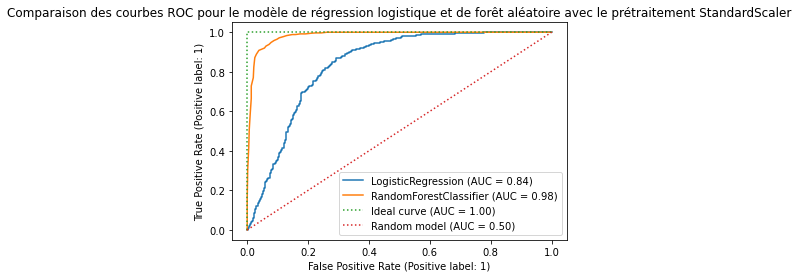

In [56]:
# Courbes ROC pour la régression logistique avec Standard Scaler

log_reg = LogisticRegression(penalty='l1', max_iter=10000, solver='saga') # default C
log_reg.fit(X_train_preprocessed_s, y_train)
forest = RandomForestClassifier(random_state=13, n_estimators=38)
forest.fit(X_train_preprocessed_s, y_train)

metrics.plot_roc_curve(log_reg, X_test_preprocessed_s, y_test, response_method='predict_proba');
fpr, tpr, thresholds = metrics.roc_curve(y_test, forest.predict_proba(X_test_preprocessed_s)[:,1])
plt.plot(fpr, tpr, label=f'RandomForestClassifier (AUC = {metrics.roc_auc_score(y_test, forest.predict_proba(X_test_preprocessed_s)[:,1]):.2f})')
plt.plot([0,0,1],[0,1,1], ':', label="Ideal curve (AUC = 1.00)")

fpr, tpr, thresholds = metrics.roc_curve(y_test, [1.]*len(y_test))
plt.plot(fpr, tpr, ':',label=f'Random model (AUC = {metrics.roc_auc_score(y_test, [1.]*len(y_test)):.2f})')
plt.legend()
plt.title("Comparaison des courbes ROC pour le modèle de régression logistique et de forêt aléatoire avec le prétraitement StandardScaler")

On constate bien que la courbe RandomForest est plus proche de l'idéal que la courbe de LogisticRegression, avec une aire sous la courbe plus proche de 1.

### 2. Autres prétraitrements et modèles

On peut essayer d'autres prétraitements et modèles.

In [28]:
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Analyse en composantes principales (on pourrait faire une sélection de variables également) à partir du prétraitement StandardScaler

pca = decomposition.PCA(n_components=2)
pca.fit(X_train_preprocessed_s)
X_train_preprocessed_projected_s = pca.transform(X_train_preprocessed_s)
X_test_preprocessed_projected_s = pca.transform(X_test_preprocessed_s)
print(X_train_preprocessed_s.shape)
print(X_train_preprocessed_projected_s.shape)
print(pca.explained_variance_ratio_)

(4800, 10)
(4800, 2)
[0.29817933 0.1985973 ]


In [31]:
# Forêt aléatoire (validation croisée) sur la projection

reg_coef = sorted([i for i in range (1, 10, 3)] + [20, 40, 60, 100, 200])
tuned_parameters = [{'n_estimators': reg_coef}]
nb_folds = 5

forest2 = RandomForestClassifier(random_state=13)
grid = GridSearchCV(forest2, tuned_parameters, cv=nb_folds, refit=True, verbose=3, scoring='f1')
grid.fit(X_train_preprocessed_projected_s, y_train)
print(grid.best_score_)
print(grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test_preprocessed_projected_s)
print(f1_score(y_test, y_pred, average='binary'))

# On pourrait étudier l'hyperparamètre de la dimension dans laquelle on projette

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ....................n_estimators=1;, score=0.580 total time=   0.0s
[CV 2/5] END ....................n_estimators=1;, score=0.590 total time=   0.0s
[CV 3/5] END ....................n_estimators=1;, score=0.625 total time=   0.0s
[CV 4/5] END ....................n_estimators=1;, score=0.588 total time=   0.0s
[CV 5/5] END ....................n_estimators=1;, score=0.577 total time=   0.0s
[CV 1/5] END ....................n_estimators=4;, score=0.547 total time=   0.0s
[CV 2/5] END ....................n_estimators=4;, score=0.527 total time=   0.0s
[CV 3/5] END ....................n_estimators=4;, score=0.587 total time=   0.0s
[CV 4/5] END ....................n_estimators=4;, score=0.559 total time=   0.0s
[CV 5/5] END ....................n_estimators=4;, score=0.527 total time=   0.0s
[CV 1/5] END ....................n_estimators=7;, score=0.585 total time=   0.0s
[CV 2/5] END ....................n_estimators=7;,

Ce modèle fait pire que répondre toujours positif.

In [34]:
# Perceptron

from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

perceptron = Perceptron(tol=1e-3, random_state=0)
perceptron.fit(X_train_preprocessed_s, y_train)
print("Perceptron", f1_score(y_test, perceptron.predict(X_test_preprocessed_s), average='binary'))

perceptron_ml = MLPClassifier(random_state=13, max_iter=10000).fit(X_train_preprocessed_s, y_train)
print("Réseau de neurones", f1_score(y_test, perceptron_ml.predict(X_test_preprocessed_s), average='binary'))

Perceptron 0.5756385068762279
Réseau de neurones 0.9053627760252365


Le perceptron fournit des résultats pires que de répondre toujours positifs : il n'est pas un modèle à choisir.
Le réseau de neurones donne des résultats corrects, même s'ils ne sont pas aussi bons que ceux de la forêt aléatoire. Il faudrait sûrement essayer de choisir les hyperparamètres de ce modèle par validation croisée et analyse pour améliorer ce résultat.

In [35]:
from sklearn import svm

# SVM

svc_model = svm.SVC()
svc_model.fit(X_train_preprocessed_s, y_train)
print(f1_score(y_test, svc_model.predict(X_test_preprocessed_s), average='binary'))

0.871559633027523


On constate un F-score moyen pour le modèle SVM.